In [1]:
%%capture --no-display

import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, get_complex_laplacian

# widget imports:
import nibabel as nib
from surfer import Brain as SB
from ipywidgets import interactive, widgets, fixed

## Examing and rendering brains for best eigenmode matches

In [2]:
%matplotlib inline

# House keeping
plt.style.use('seaborn')
data_dir = '../../data/'
hcp_dir = "../../data"

# Load Pablo's Yeo 2017 canonical network maps
com_dk = np.load(
    "../../data/com_dk.npy",
    allow_pickle = True
).item()
DK_df_normalized = pd.read_csv(
    "../../data/DK_dictionary_normalized.csv"
).set_index("Unnamed: 0")

# binarize:
ub, lb = 1, 0 #define binary boundaries

DKfc_binarized = pd.DataFrame(
    [], index=DK_df_normalized.index, columns=DK_df_normalized.columns
)
for name in DK_df_normalized.index:
    u = np.mean(np.nan_to_num(DK_df_normalized.loc[name].values))
    s = np.std(np.nan_to_num(DK_df_normalized.loc[name].values))
    threshold = u - s * 0.1
    DKfc_binarized.loc[name] = np.where(
        DK_df_normalized.loc[name].values > threshold, ub, lb
    )

### Loading Basin Hopping results:
Start with Default network:

In [3]:
colnames = ['Fun','x']
indnames = [0,1,2,3,4]
default_evals = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,5):
    h5_path = path.get_file_path('Default{}_BH_dice.h5'.format(i))
    bh_default = path.read_hdf5(h5_path)
    default_evals.at[i,'Fun'] = bh_default['fun']
    default_evals.at[i,'x'] = np.round(bh_default['x'],3)
    
default_evals

,Fun,x
0,0.375,"[1.758, 4.509, 23.95]"
1,0.375,"[1.758, 4.509, 23.95]"
2,0.367,"[5.91, 4.912, 2.749]"
3,0.375,"[27.323, 1.11, 5.578]"
4,0.344,"[19.056, 3.227, 1.454]"


Dorsal Attention:

In [4]:
dorsal_evals = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,5):
    h5_path = path.get_file_path('Dorsal_Attention{}_BH_dice.h5'.format(i))
    bh_dorsal = path.read_hdf5(h5_path)
    dorsal_evals.at[i,'Fun'] = bh_dorsal['fun']
    dorsal_evals.at[i,'x'] = np.round(bh_dorsal['x'],3)

dorsal_evals

,Fun,x
0,0.469,"[2.0, 0.5, 10.0]"
1,0.469,"[2.0, 0.5, 10.0]"
2,0.469,"[5.797, 0.563, 28.822]"
3,0.294,"[29.034, 3.262, 2.323]"
4,0.294,"[18.451, 0.887, 1.472]"


In [19]:
# Draw:
h5_path = path.get_file_path('Dorsal_Attention3_BH_dice.h5')
bh_dorsal = path.read_hdf5(h5_path)
d3 = [bh_dorsal['LinRegResults'][i]['r2score'] for i in range(len(bh_dorsal['LinRegResults']))]

h5_path = path.get_file_path('Dorsal_Attention4_BH_dice.h5')
bh_dorsal = path.read_hdf5(h5_path)
d4 = [bh_dorsal['LinRegResults'][i]['r2score'] for i in range(len(bh_dorsal['LinRegResults']))]

print(d3)
print(d4) # pick d4 cuz 0.0513 vs 0.0518

[0.25853579010998207, 0.16190345744993656, 0.15538740576253965, 0.11555917831673615, 0.09131352246149978, 0.07519533839118844, 0.0680968688996643, 0.06236463459924137, 0.05730379498540063, 0.05189627410101256]
[0.25863217651509096, 0.16118930607643528, 0.1540273598297941, 0.11473556309315995, 0.09074790681406893, 0.07482353798632872, 0.0678428431442668, 0.06218339886578272, 0.05715616936832282, 0.05134962738665614]


Frontoparietal:

In [6]:
front_evals = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,5):
    h5_path = path.get_file_path('Frontoparietal{}_BH_dice.h5'.format(i))
    bh_front = path.read_hdf5(h5_path)
    front_evals.at[i,'Fun'] = bh_front['fun']
    front_evals.at[i,'x'] = np.round(bh_front['x'],3)

front_evals

,Fun,x
0,0.429,"[8.337, 4.838, 15.645]"
1,0.429,"[8.337, 4.838, 15.645]"
2,0.429,"[11.104, 1.279, 21.2]"
3,0.367,"[33.093, 1.629, 3.911]"
4,0.429,"[9.581, 2.331, 15.163]"


In [7]:
limbic_evals = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,5):
    h5_path = path.get_file_path('Limbic{}_BH_dice.h5'.format(i))
    bh_limbic = path.read_hdf5(h5_path)
    limbic_evals.at[i,'Fun'] = bh_limbic['fun']
    limbic_evals.at[i,'x'] = np.round(bh_limbic['x'],3)

limbic_evals # in case of a draw, take lowest reconstruction error

,Fun,x
0,0.224,"[6.565, 3.033, 1.249]"
1,0.25,"[28.983, 3.125, 13.267]"
2,0.224,"[14.479, 0.794, 2.77]"
3,0.28,"[30.724, 4.132, 2.261]"
4,0.24,"[8.273, 1.111, 1.611]"


In [13]:
# Draw:
h5_path = path.get_file_path('Limbic0_BH_dice.h5')
bh_limbic = path.read_hdf5(h5_path)
l0 = [bh_limbic['LinRegResults'][i]['r2score'] for i in range(len(bh_limbic['LinRegResults']))]

h5_path = path.get_file_path('Limbic2_BH_dice.h5')
bh_limbic = path.read_hdf5(h5_path)
l2 = [bh_limbic['LinRegResults'][i]['r2score'] for i in range(len(bh_limbic['LinRegResults']))]

print(l0)
print(l2) # take l2 because 0.28823 vs. 0.28911

[0.4439489926570859, 0.3765362046316167, 0.36295812156689417, 0.33652042027342316, 0.33150234158583347, 0.3337830687090604, 0.3213634152689387, 0.2914403080127934, 0.29169108432876273, 0.28910619073529015]
[0.4444342452543505, 0.3756458087855024, 0.36122044444337637, 0.3349933544821469, 0.32976221334131794, 0.3163742141358954, 0.3192924201303265, 0.29024436850943264, 0.29065003786327837, 0.28822975486206204]


Somatomotor:

In [8]:
motor_evals = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,5):
    h5_path = path.get_file_path('Somatomotor{}_BH_dice.h5'.format(i))
    bh_motor = path.read_hdf5(h5_path)
    motor_evals.at[i,'Fun'] = bh_motor['fun']
    motor_evals.at[i,'x'] = np.round(bh_motor['x'],3)

motor_evals # in case of a draw, take lowest reconstruction error

,Fun,x
0,0.44,"[2.0, 0.5, 10.0]"
1,0.44,"[8.481, 2.355, 20.758]"
2,0.44,"[12.209, 3.296, 29.147]"
3,0.333,"[21.316, 1.967, 2.591]"
4,0.346,"[14.46, 2.418, 1.669]"


Ventral Attention:

In [10]:
ventral_evals = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,5):
    h5_path = path.get_file_path('Ventral_Attention{}_BH_dice.h5'.format(i))
    bh_ventral = path.read_hdf5(h5_path)
    ventral_evals.at[i,'Fun'] = bh_ventral['fun']
    ventral_evals.at[i,'x'] = np.round(bh_ventral['x'],3)

ventral_evals # in case of a draw, take lowest reconstruction error

,Fun,x
0,0.37,"[13.719, 2.715, 0.879]"
1,0.412,"[5.268, 1.486, 0.258]"
2,0.37,"[9.506, 0.952, 0.608]"
3,0.36,"[26.092, 2.677, 1.83]"
4,0.36,"[43.973, 4.505, 3.047]"


In [14]:
# Draw:
h5_path = path.get_file_path('Ventral_Attention3_BH_dice.h5')
bh_ventral = path.read_hdf5(h5_path)
v3 = [bh_ventral['LinRegResults'][i]['r2score'] for i in range(len(bh_ventral['LinRegResults']))]

h5_path = path.get_file_path('Ventral_Attention4_BH_dice.h5')
bh_ventral = path.read_hdf5(h5_path)
v4 = [bh_ventral['LinRegResults'][i]['r2score'] for i in range(len(bh_ventral['LinRegResults']))]

print(v3)
print(v4) # take v3 because 0.023 vs. 0.025

[0.09405046448268828, 0.08332434011488513, 0.05511512427154839, 0.05059830927537524, 0.04063771851770018, 0.03546676459713392, 0.031218552989982527, 0.02735597269391221, 0.025507978749578854, 0.023500888091635547]
[0.09336107064900145, 0.0832102106179003, 0.06931651856692266, 0.05164613322447021, 0.04174047386381867, 0.037109915592976175, 0.03171251227967936, 0.02899738654070608, 0.02669424795609548, 0.02517793953038179]


Visual:

In [12]:
visual_evals = pd.DataFrame(columns = colnames, index = indnames)

for i in np.arange(0,5):
    h5_path = path.get_file_path('Visual{}_BH_dice.h5'.format(i))
    bh_visual = path.read_hdf5(h5_path)
    visual_evals.at[i,'Fun'] = bh_visual['fun']
    visual_evals.at[i,'x'] = np.round(bh_visual['x'],3)

visual_evals # in case of a draw, take lowest reconstruction error

,Fun,x
0,0.302,"[20.005, 4.117, 4.959]"
1,0.302,"[34.284, 2.228, 8.562]"
2,0.409,"[1.531, 2.225, 19.327]"
3,0.273,"[27.996, 2.272, 2.391]"
4,0.302,"[19.777, 4.484, 4.925]"


Concatenate reconstruction errors and plot to check for optimal number of sorted eigenmodes:

Text(0, 0.5, '$r^{2}$ score')

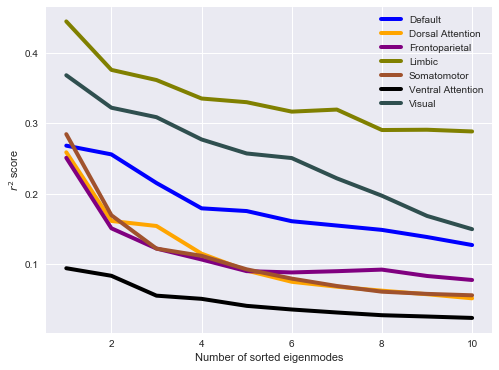

In [3]:
from cycler import cycler

r2s = np.zeros([7,10])

h5_path = path.get_file_path('Default4_BH_dice.h5')
bh_default = path.read_hdf5(h5_path)
r2s[0,:] = [bh_default['LinRegResults'][i]['r2score'] for i in range(len(bh_default['LinRegResults']))]

h5_path = path.get_file_path('Dorsal_Attention4_BH_dice.h5')
bh_dorsal = path.read_hdf5(h5_path)
r2s[1,:] = [bh_dorsal['LinRegResults'][i]['r2score'] for i in range(len(bh_dorsal['LinRegResults']))]

h5_path = path.get_file_path('Frontoparietal3_BH_dice.h5')
bh_front = path.read_hdf5(h5_path)
r2s[2,:] = [bh_front['LinRegResults'][i]['r2score'] for i in range(len(bh_front['LinRegResults']))]

h5_path = path.get_file_path('Limbic2_BH_dice.h5')
bh_limbic = path.read_hdf5(h5_path)
r2s[3,:] = [bh_limbic['LinRegResults'][i]['r2score'] for i in range(len(bh_limbic['LinRegResults']))]

h5_path = path.get_file_path('Somatomotor3_BH_dice.h5')
bh_motor = path.read_hdf5(h5_path)
r2s[4,:] = [bh_motor['LinRegResults'][i]['r2score'] for i in range(len(bh_motor['LinRegResults']))]

h5_path = path.get_file_path('Ventral_Attention3_BH_dice.h5')
bh_ventral = path.read_hdf5(h5_path)
r2s[5,:] = [bh_ventral['LinRegResults'][i]['r2score'] for i in range(len(bh_ventral['LinRegResults']))]

h5_path = path.get_file_path('Visual3_BH_dice.h5')
bh_visual = path.read_hdf5(h5_path)
r2s[6,:] = [bh_visual['LinRegResults'][i]['r2score'] for i in range(len(bh_visual['LinRegResults']))]

# Plot
x = np.arange(1,11)
plt.figure('Reconstruction Scores', figsize = [8,6])
custom_cycler = (cycler(color = ['blue','orange','purple','olive',
                          'sienna','black','darkslategray']))
plt.gca().set_prop_cycle(custom_cycler)
plt.plot(x, r2s.transpose(), linewidth = 4)
plt.legend(['Default','Dorsal Attention','Frontoparietal','Limbic','Somatomotor','Ventral Attention','Visual'],
          fontsize = 'medium', loc = 'upperright')
plt.xlabel('Number of sorted eigenmodes')
plt.ylabel('$r^{2}$ score')

Expand the above plot to 50 eigenmodes and DICE:

In [22]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import minmax_scale

w = 2*np.pi*bh_default['x'][0]

#create brain object:
fc_brain = Brain.Brain()
fc_brain.add_connectome(hcp_dir)
fc_brain.reorder_connectome(fc_brain.connectome, fc_brain.distance_matrix)
fc_brain.bi_symmetric_c()
fc_brain.reduce_extreme_dir()

fc_brain.add_laplacian_eigenmodes(w = w, alpha = bh_default['x'][1], speed = bh_default['x'][2])
fc_brain.binary_eigenmodes = np.where(fc_brain.norm_eigenmodes > 0.6, 1, 0)
opt_dice = eigenmode.get_dice_df(fc_brain.binary_eigenmodes, DKfc_binarized)
ntw_opt_dice = np.round(opt_dice['Default'].values.astype(np.double),3)
ordered_dice = np.argsort(ntw_opt_dice)

K = 5
selected_eigs = fc_brain.norm_eigenmodes[:,ordered_dice[0:K+1]]
canon_network = np.nan_to_num(DK_df_normalized.loc['Default'].values).reshape(-1,1)
regr = LinearRegression()
regr.fit(canon_network, selected_eigs)
comb_eigmodes = np.dot(selected_eigs, np.asarray(regr.coef_))
comb_eigmodes = np.squeeze(minmax_scale(comb_eigmodes))

In [35]:
corrs = np.zeros([86,1])
for e in np.arange(0,86):
    corrs[e] = pearsonr(np.squeeze(canon_network),fc_brain.norm_eigenmodes[:,e])[0]
    
len(corrs)

86

In [26]:
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance
from sklearn.preprocessing import minmax_scale
from scipy.stats import pearsonr

def compute_linreg_scores(brain, fnetworks, df_binarized, f, a, s, fc_name, num_em):
    w = 2*np.pi*f
    
    brain.add_laplacian_eigenmodes(w = w, alpha = a, speed = s)
    brain.binary_eigenmodes = np.where(brain.norm_eigenmodes > 0.6, 1, 0)
    opt_dice = eigenmode.get_dice_df(brain.binary_eigenmodes, df_binarized)
    ntw_opt_dice = np.round(opt_dice[fc_name].values.astype(np.double),3)
    ordered_dice = np.argsort(ntw_opt_dice)
    assert ntw_opt_dice[ordered_dice[1]] > ntw_opt_dice[ordered_dice[0]]
    
    cumulative_dice = np.zeros([num_em,1])
    cumulative_regr = np.zeros([num_em,1])
    cumulative_corr = np.zeros([num_em,1])
    num_canonical = np.count_nonzero(df_binarized.loc[fc_name].values)
    thresh_vec = np.linspace(0.1,0.8,30)
    binary_count = np.zeros(thresh_vec.shape)
    
    for k in np.arange(0,num_em):
        selected_eigs = brain.norm_eigenmodes[:,ordered_dice[0:k+1]]
        canon_network = np.nan_to_num(fnetworks.loc[fc_name].values).reshape(-1,1)
        regr = LinearRegression()
        regr.fit(canon_network, selected_eigs)
        # regression fit
        cumulative_regr[k] = regr.score(canon_network, selected_eigs) #r2 score
        # dice:
        comb_eigmodes = np.dot(selected_eigs, np.asarray(regr.coef_))
        comb_eigmodes = np.squeeze(minmax_scale(comb_eigmodes))
        ## binarize each combination differently:
        for i in np.arange(0,len(thresh_vec)):
            binary_mat = np.where(comb_eigmodes > thresh_vec[i],1,0)
            binary_count[i] = np.count_nonzero(binary_mat)
        
        bin_num = np.abs(binary_count - num_canonical).argmin()
        binary_comb = np.where(comb_eigmodes > thresh_vec[bin_num], 1, 0)
        print('{} element count: {}, eigenmode element count: {}'.format(fc_name, num_canonical, np.count_nonzero(binary_comb)))
        cumulative_dice[k] = 1-distance.dice(binary_comb, df_binarized.loc[fc_name].values)
        # spatial correlation
        cumulative_corr[k] = pearsonr(np.squeeze(canon_network), comb_eigmodes)[0]
        
    return np.squeeze(cumulative_regr), np.squeeze(cumulative_dice), np.squeeze(cumulative_corr)

[19.05551991  3.22748412  1.45362257]
Default element count: 32, eigenmode element count: 34
Default element count: 32, eigenmode element count: 33
Default element count: 32, eigenmode element count: 33
Default element count: 32, eigenmode element count: 32
Default element count: 32, eigenmode element count: 32
Default element count: 32, eigenmode element count: 32
Default element count: 32, eigenmode element count: 33
Default element count: 32, eigenmode element count: 31
Default element count: 32, eigenmode element count: 33
Default element count: 32, eigenmode element count: 31
Default element count: 32, eigenmode element count: 31
Default element count: 32, eigenmode element count: 32
Default element count: 32, eigenmode element count: 33
Default element count: 32, eigenmode element count: 33
Default element count: 32, eigenmode element count: 33
Default element count: 32, eigenmode element count: 33
Default element count: 32, eigenmode element count: 33
Default element count: 32, 

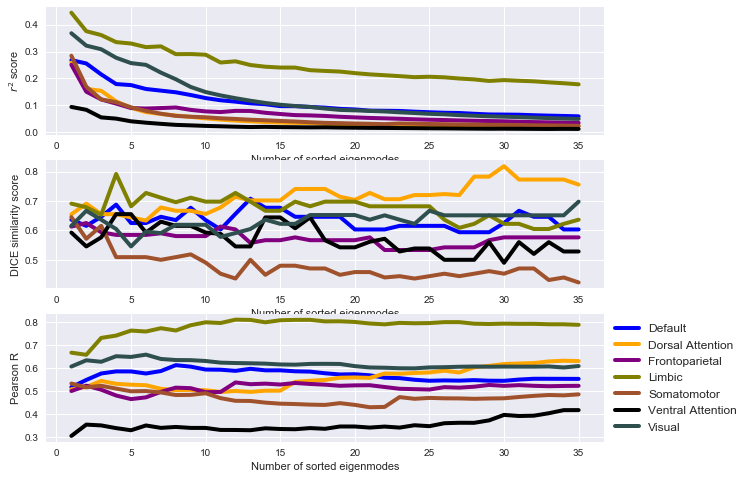

In [27]:
K = 35 # for number of eigenmodes
print(bh_default['x'])

#create brain object:
fc_brain = Brain.Brain()
fc_brain.add_connectome(hcp_dir)
fc_brain.reorder_connectome(fc_brain.connectome, fc_brain.distance_matrix)
fc_brain.bi_symmetric_c()
fc_brain.reduce_extreme_dir()

regr_all = np.zeros([K,7]) 
dice_all = np.zeros([K,7])
corr_all = np.zeros([K,7])
regr_all[:,0], dice_all[:,0], corr_all[:,0] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_default['x'][0], a = bh_default['x'][1], 
                                           s = bh_default['x'][2], fc_name = 'Default', num_em = K)

regr_all[:,1], dice_all[:,1], corr_all[:,1] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_dorsal['x'][0], a = bh_dorsal['x'][1], 
                                           s = bh_dorsal['x'][2], fc_name = 'Dorsal_Attention', num_em = K)

regr_all[:,2], dice_all[:,2], corr_all[:,2] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_front['x'][0], a = bh_front['x'][1], 
                                           s = bh_front['x'][2], fc_name = 'Frontoparietal', num_em = K)

regr_all[:,3], dice_all[:,3], corr_all[:,3] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_limbic['x'][0], a = bh_limbic['x'][1], 
                                           s = bh_limbic['x'][2], fc_name = 'Limbic', num_em = K)

regr_all[:,4], dice_all[:,4], corr_all[:,4] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_motor['x'][0], a = bh_motor['x'][1], 
                                           s = bh_motor['x'][2], fc_name = 'Somatomotor', num_em = K)

regr_all[:,5], dice_all[:,5], corr_all[:,5] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_ventral['x'][0], a = bh_ventral['x'][1], 
                                           s = bh_ventral['x'][2], fc_name = 'Ventral_Attention', num_em = K)

regr_all[:,6], dice_all[:,6], corr_all[:,6] = compute_linreg_scores(fc_brain, DK_df_normalized, DKfc_binarized, f = bh_visual['x'][0], a = bh_visual['x'][1], 
                                           s = bh_visual['x'][2], fc_name = 'Visual', num_em = K)
# Plot
x = np.arange(1,K+1)
plt.figure('Reconstruction Scores', figsize = [10,8])
plt.subplot(3,1,1)
custom_cycler = (cycler(color = ['blue','orange','purple','olive',
                          'sienna','black','darkslategray']))
plt.gca().set_prop_cycle(custom_cycler)
plt.plot(x, regr_all, linewidth = 4)
plt.xlabel('Number of sorted eigenmodes')
plt.ylabel('$r^{2}$ score')

plt.subplot(3,1,2)
plt.gca().set_prop_cycle(custom_cycler)
plt.plot(x, dice_all, linewidth = 4)
plt.xlabel('Number of sorted eigenmodes')
plt.ylabel('DICE similarity score')

plt.subplot(3,1,3)
plt.gca().set_prop_cycle(custom_cycler)
plt.plot(x, corr_all, linewidth = 4)
plt.xlabel('Number of sorted eigenmodes')
plt.ylabel('Pearson R')
plt.legend(['Default','Dorsal Attention','Frontoparietal','Limbic','Somatomotor','Ventral Attention','Visual'],
          fontsize = 'large', loc = 'center left',  bbox_to_anchor=(1, 0.5))

In [ ]:
# Compute eigenmode dice with Brain:
dft_brain = Brain.Brain()
dft_brain.add_connectome(hcp_dir)
dft_brain.reorder_connectome(dft_brain.connectome, dft_brain.distance_matrix)
dft_brain.bi_symmetric_c()
dft_brain.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_default['x'][0]
dft_brain.add_laplacian_eigenmodes(w, alpha = bh_default['x'][1], speed = bh_default['x'][2])

# binarize and compute dice:
dft_brain.binary_eigenmodes = np.where(dft_brain.norm_eigenmodes > 0.6, 1, 0)
dft_dice = eigenmode.get_dice_df(dft_brain.binary_eigenmodes, DKfc_binarized)
# Compute mean Dice for chosen network:
dice_scores = 1-np.round(dft_dice['Default'].values.astype(np.double),3)
mean_dice = np.mean(dice_scores)
print("mean dice dissimilarity score: ", mean_dice)

In [ ]:
np.min(dice_scores)

In [ ]:
ordered_dice = np.argsort(dice_scores)
ordered_dice

In [ ]:
dice_scores[78]

In [ ]:
from nilearn import plotting
from matplotlib import cm

## Function for plotting with nilearn
def plot_glass_brain(coords, scores, cmap_name):
    """ Plot transparent brain renders
    Args:
        - color (list): Color indices
        - coords 
        - size
    Returns:
        -matplotlib object
    """
    cmap = cm.get_cmap(cmap_name)
    data = np.nan_to_num(scores)
    size = data*500
    #color = cmap((size/np.max(size)))
    color = cmap(data)
    connectome_array = np.array([[0]*86]*86)
    plotting.plot_connectome(connectome_array, coords, node_size = size, node_color = color, display_mode = 'xz')
    plt.gcf().set_size_inches(10, 5)

# plot:
plt.figure('Default System', figsize = [10,8])
plt.hist(dice_scores, bins = 8, density = True, histtype = 'bar')
xvals = plt.xticks()[0]
xmin, xmax = min(xvals), max(xvals)
xbins = np.linspace(xmin, xmax, len(dice_scores))
mu, sigma = stats.norm.fit(dice_scores)
gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

In [ ]:
np.argmax(dice_scores)

In [ ]:
binarized_eig = np.where(dft_brain.norm_eigenmodes[:,52] > 0.6, 1, 0)
np.round(dft_brain.norm_eigenmodes[:,52],2)

In [ ]:
np.round(DK_df_normalized.loc['Default'].values,2)

In [ ]:
from scipy.spatial import distance
u = np.mean(np.nan_to_num(DK_df_normalized.loc['Default'].values))
s = np.std(np.nan_to_num(DK_df_normalized.loc['Default'].values))
threshold = u - s * 0.1
distance.dice(np.where(dft_brain.norm_eigenmodes[:,61]>0.6,1,0), np.where(np.nan_to_num(DK_df_normalized.loc['Default'].values)>threshold,1,0))

In [ ]:
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])
eigscore = dft_brain.norm_eigenmodes[:,61]
plot_glass_brain(coords, eigscore, 'coolwarm')

In [ ]:
np.arange(1,11)

Trying linear regression:

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

k = 5 # number of top eigen modes to regress:
Y = dft_brain.norm_eigenmodes[:,ordered_dice[0:k]]
X = np.nan_to_num(DK_df_normalized.loc['Default'].values).reshape(-1,1)
regr = LinearRegression()
regr.fit(X,Y)
print(regr.score(X,Y))

In [ ]:
from sklearn.preprocessing import minmax_scale
lin_comb_y = np.dot(Y,np.asarray(regr.coef_))
scaled_y = np.squeeze(minmax_scale(lin_comb_y))

In [ ]:
plot_glass_brain(coords, np.asarray(scaled_y), 'coolwarm')

In [ ]:
a = np.array([[[1]*2]*5])
b = np.array([1,2])
print(a)
print(b.shape)
np.dot(a,b)

In [ ]:
%gui qt

# set up Pysurfer variables
subject_id = "fsaverage"
hemi = "split"
surf = "inflated"

"""
Bring up the visualization.
"""
#brain = Brain(subject_id, hemi , surf, background="white", views = ['lat','med'])
dft_SB = SB(subject_id, hemi, surf, background = "white", title = "Default freq = 4.5, alpha = 5.3, v = 8.2", views=['lat', 'med'])
#limb_SB.add_text(x = 0.5, y = 0.9, text = "Eig Number , frequency = , speed = ", name = "eiglabel")

"""
Read in the automatic parcellation of sulci and gyri.
"""

# left side:
hemi_side = "lh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)
lh_norm_eigs = dft_brain.norm_eigenmodes[:,np.argmin(dice_scores)]
lh_padded_eigs = np.insert(lh_norm_eigs, [0, 3], [0, 0])
dft_lh = lh_padded_eigs[labels]
dft_SB.add_data(dft_lh, hemi = 'lh', thresh = 0, colormap = "jet", remove_existing = True)

hemi_side = "rh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)

rh_norm_eigs = dft_brain.norm_eigenmodes[34:68,np.argmin(dice_scores)]
rh_padded_eigs = np.insert(rh_norm_eigs, [0,3],[0,0])
dft_rh = rh_padded_eigs[labels]
dft_SB.add_data(dft_rh, hemi = 'rh', thresh = 0, colormap = "jet", remove_existing = True)

In [ ]:
print(np.min(dice_scores))

#### Dorsal attention network

In [ ]:
# load results:
h5_path = path.get_file_path('Dorsal_Attention_BH_dice.h5')
bh_dorattn = path.read_hdf5(h5_path)
bh_dorattn

#### Frontoparietal

In [ ]:
h5_path = path.get_file_path('Frontoparietal_BH_dice.h5')
bh_ftpt = path.read_hdf5(h5_path)
bh_ftpt

#### Limbic

In [ ]:
h5_path = path.get_file_path('Limbic_BH_dice.h5')
bh_limb = path.read_hdf5(h5_path)
bh_limb

Plot eigenmode dice dissimilarity scores:

In [ ]:
# Compute eigenmode dice with Brain:
limbic = Brain.Brain()
limbic.add_connectome(hcp_dir)
limbic.reorder_connectome(limbic.connectome, limbic.distance_matrix)
limbic.bi_symmetric_c()
limbic.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_limb['x'][0]
limbic.add_laplacian_eigenmodes(w, alpha = bh_limb['x'][1], speed = bh_limb['x'][2])

# binarize and compute dice:
limbic.binary_eigenmodes = np.where(limbic.norm_eigenmodes > 0.6, 1, 0)
limbic_dice = eigenmode.get_dice_df(limbic.binary_eigenmodes, DKfc_binarized)
# Compute mean Dice for chosen network:
dice_scores = 1-np.round(limbic_dice['Limbic'].values.astype(np.double),3)
mean_dice = np.mean(dice_scores)
print("mean dice dissimilarity score: ", mean_dice)

# plot:
plt.figure('Limbic System')
plt.hist(dice_scores, bins = 8, density = True, histtype = 'bar')
xvals = plt.xticks()[0]
xmin, xmax = min(xvals), max(xvals)
xbins = np.linspace(xmin, xmax, len(dice_scores))
mu, sigma = stats.norm.fit(dice_scores)
gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

In [ ]:
np.argmin(dice_scores)

In [ ]:
eigscore = limbic.norm_eigenmodes[:,np.argmin(dice_scores)]
plot_glass_brain(coords, eigscore, 'coolwarm')

Render brain for best dice score:

In [ ]:
%gui qt

# set up Pysurfer variables
subject_id = "fsaverage"
hemi = "split"
surf = "inflated"

"""
Bring up the visualization.
"""
#brain = Brain(subject_id, hemi , surf, background="white", views = ['lat','med'])
limb_SB = SB(subject_id, hemi, surf, background = "white", title = "Limbic freq = 4.5, alpha = 5.3, v = 8.2", views=['lat', 'med'])
#limb_SB.add_text(x = 0.5, y = 0.9, text = "Eig Number , frequency = , speed = ", name = "eiglabel")

"""
Read in the automatic parcellation of sulci and gyri.
"""

# left side:
hemi_side = "lh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)
lh_norm_eigs = limbic.norm_eigenmodes[:,np.argmax(dice_scores)]
lh_padded_eigs = np.insert(lh_norm_eigs, [0, 3], [0, 0])
limb_lh = lh_padded_eigs[labels]
limb_SB.add_data(limb_lh, hemi = 'lh', thresh = 0, colormap = "jet", remove_existing = True)

hemi_side = "rh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)

rh_norm_eigs = limbic.norm_eigenmodes[34:68,np.argmax(dice_scores)]
rh_padded_eigs = np.insert(rh_norm_eigs, [0,3],[0,0])
limb_rh = rh_padded_eigs[labels]
limb_SB.add_data(limb_rh, hemi = 'rh', thresh = 0, colormap = "jet", remove_existing = True)